In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
!pip install Transformers


In [3]:
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer, BertForSequenceClassification, pipeline
from sklearn.preprocessing import LabelEncoder

In [4]:
!pip install Torch

In [5]:
import torch

In [6]:
df=pd.read_csv('/content/DatasetCopy.csv')
df

,page_id,text,label,Pattern Category
0,1012.0,FLASH SALE | LIMITED TIME ONLY Shop Now,1.0,Urgency
1,158.0,Pillowcases & Shams,0.0,Not Dark Pattern
2,NaN,Limited time offer: Buy now or miss out,2.0,Semi Dark Pattern
3,108.0,Write a review,0.0,Not Dark Pattern
4,1425.0,"To start your return, simply click on the foll...",0.0,Not Dark Pattern
...,...,...,...,...
2451,1304.0,Bra Panty Set,0.0,Not Dark Pattern
2452,1038.0,DressesFootwearHatsHoodies & SweatshirtsJersey...,0.0,Not Dark Pattern
2453,1081.0,Only 4 left in stock,1.0,Scarcity
2454,767.0,Trending Players,0.0,Not Dark Pattern


In [7]:
df.drop("page_id", inplace=True, axis=1)

In [8]:
df = df.dropna()
df = df.reset_index(drop=True)

In [9]:
df

,text,label,Pattern Category
0,FLASH SALE | LIMITED TIME ONLY Shop Now,1.0,Urgency
1,Pillowcases & Shams,0.0,Not Dark Pattern
2,Limited time offer: Buy now or miss out,2.0,Semi Dark Pattern
3,Write a review,0.0,Not Dark Pattern
4,"To start your return, simply click on the foll...",0.0,Not Dark Pattern
...,...,...,...
2443,Bra Panty Set,0.0,Not Dark Pattern
2444,DressesFootwearHatsHoodies & SweatshirtsJersey...,0.0,Not Dark Pattern
2445,Only 4 left in stock,1.0,Scarcity
2446,Trending Players,0.0,Not Dark Pattern


In [10]:
df.isnull().sum()

text                0
label               0
Pattern Category    0
dtype: int64

In [11]:
df.groupby('Pattern Category').describe()

label                                   
                    count mean  std  min  25%  50%  75%  max
Pattern Category                                            
Forced Action         4.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Misdirection        195.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Not Dark Pattern   1176.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
Obstruction          27.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Scarcity            414.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Semi Dark Pattern   100.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
Sneaking             12.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Social Proof        312.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Urgency             208.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [12]:
fine = df['Pattern Category'].unique().tolist()
fine = [s.strip() for s in fine]
fine

['Urgency',
 'Not Dark Pattern',
 'Semi Dark Pattern',
 'Scarcity',
 'Misdirection',
 'Social Proof',
 'Obstruction',
 'Sneaking',
 'Forced Action']

In [13]:
num_fine = len(fine)
id2fine = {id:fine for id, fine in enumerate(fine)}
fine2id = {fine:id for id, fine in enumerate(fine)}

In [14]:
df.drop('label', axis=1, inplace=True)
df.head()

,text,Pattern Category
0,FLASH SALE | LIMITED TIME ONLY Shop Now,Urgency
1,Pillowcases & Shams,Not Dark Pattern
2,Limited time offer: Buy now or miss out,Semi Dark Pattern
3,Write a review,Not Dark Pattern
4,"To start your return, simply click on the foll...",Not Dark Pattern


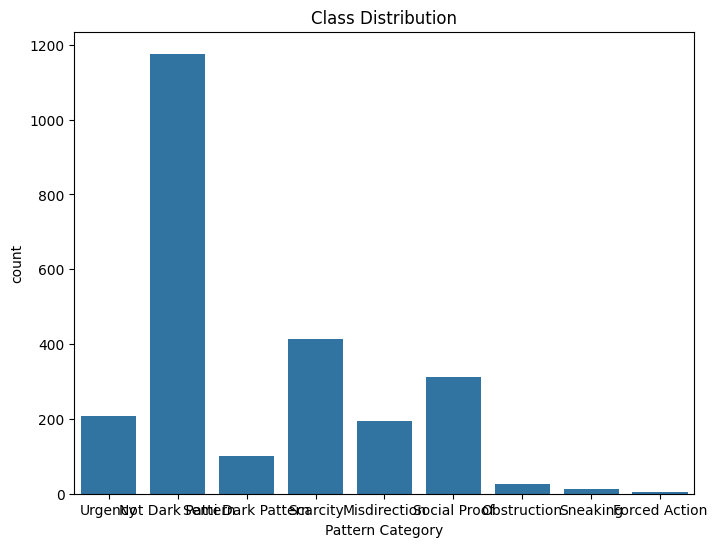

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Pattern Category', data=df)
plt.title('Class Distribution')
plt.show()

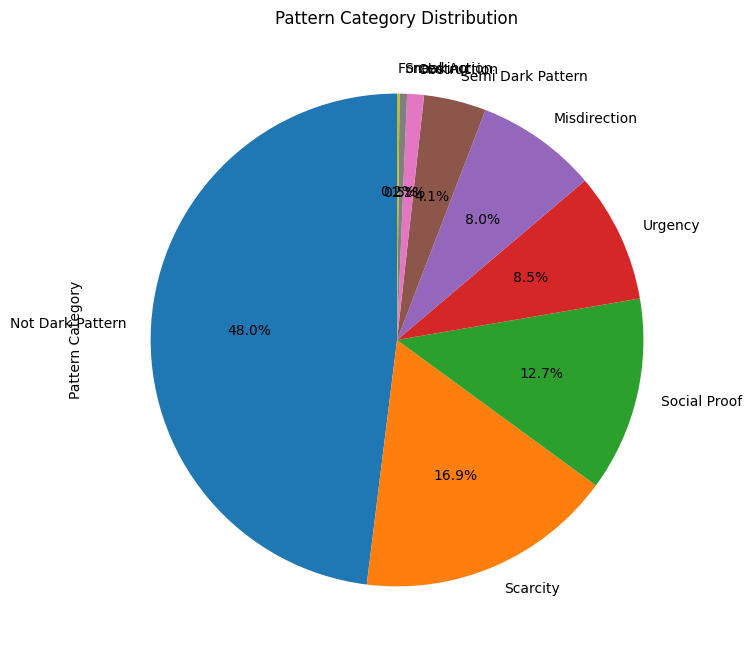

In [16]:

plt.figure(figsize=(8, 8))
df['Pattern Category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Pattern Category Distribution')
plt.show()


In [17]:
df['labels'] = df['Pattern Category'].map(lambda x: fine2id[x.strip()])
df

,text,Pattern Category,labels
0,FLASH SALE | LIMITED TIME ONLY Shop Now,Urgency,0
1,Pillowcases & Shams,Not Dark Pattern,1
2,Limited time offer: Buy now or miss out,Semi Dark Pattern,2
3,Write a review,Not Dark Pattern,1
4,"To start your return, simply click on the foll...",Not Dark Pattern,1
...,...,...,...
2443,Bra Panty Set,Not Dark Pattern,1
2444,DressesFootwearHatsHoodies & SweatshirtsJersey...,Not Dark Pattern,1
2445,Only 4 left in stock,Scarcity,3
2446,Trending Players,Not Dark Pattern,1


In [18]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [19]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_fine,
                                                      id2label=id2fine, label2id=fine2id)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [20]:
SIZE = df.shape[0]
train_texts = list(df.text[:SIZE//2])
val_texts = list(df.text[SIZE//2: (SIZE//2) + (SIZE//4)])
test_texts = list(df.text[(3*SIZE)//4:])
train_labels = list(df.labels[:SIZE//2])
val_labels = list(df.labels[SIZE//2: (SIZE//2) + (SIZE//4)])
test_labels = list(df.labels[(3*SIZE)//4:])

In [21]:
len(train_texts), len(val_texts), len(test_texts)

(1224, 612, 612)

In [22]:

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
if len(val_texts) > 0:
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)
else:
    val_encodings = None  # or handle it accordingly)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [23]:
from torch.utils.data import Dataset

In [24]:
class Dataloader(Dataset):
    def __init__(self, encodings, labels):

        print("Encodings:", encodings)
        print("Labels:", labels)
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [25]:
train_dataloader = Dataloader(train_encodings, train_labels)
val_dataloader = Dataloader(val_encodings, val_labels)
test_dataloader = Dataloader(test_encodings, test_labels)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
from transformers import TrainingArguments, Trainer

In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [28]:
!pip install accelerate

In [29]:
!pip install accelerate>=0.20.1

In [30]:
training_args = TrainingArguments(
    output_dir="./TTC4908Model",
    do_train=True,
    do_eval=True,

    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy="steps",

    logging_dir="./multi-class-logs",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=False,
    load_best_model_at_end=True,
)


In [31]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,

    # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics
)

In [32]:
!pip install transformers==4.12.0 accelerate==0.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 27.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects


In [33]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.832900,1.296729,0.633987,0.237162,0.282098,0.249457
100,0.871800,0.399330,0.921569,0.567050,0.582202,0.554964
150,0.292100,0.338761,0.916667,0.558863,0.597595,0.536171
200,0.126400,0.238312,0.944444,0.671414,0.695283,0.651324


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

TrainOutput(global_step=231, training_loss=0.6916315493645606, metrics={'train_runtime': 129.8588, 'train_samples_per_second': 28.277, 'train_steps_per_second': 1.779, 'total_flos': 307600266341808.0, 'train_loss': 0.6916315493645606, 'epoch': 3.0})

In [34]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs['logits'].softmax(1)
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label

    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar

    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [35]:
model_path = "DPBH_BERT_Fine_Tuned_Model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('DPBH_BERT_Fine_Tuned_Model/tokenizer_config.json',
 'DPBH_BERT_Fine_Tuned_Model/special_tokens_map.json',
 'DPBH_BERT_Fine_Tuned_Model/vocab.txt',
 'DPBH_BERT_Fine_Tuned_Model/added_tokens.json',
 'DPBH_BERT_Fine_Tuned_Model/tokenizer.json')

In [36]:
from transformers import BertTokenizerFast

In [37]:

model_path = "DPBH_BERT_Fine_Tuned_Model"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [38]:
nlp("42 sold in last 24 hours")

[{'label': 'Social Proof', 'score': 0.987355649471283}]

In [39]:
!pip install selenium

!pip install requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.2/460.2 kB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


In [40]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service


chrome_options = Options()
chrome_options.add_argument("--headless")  # Use headless mode if you don't want a visible browser window

service = Service(executable_path="/content/chromedriver.exe")
options = webdriver.ChromeOptions()
options.add_argument("--headless")  # Uncomment this line if you want headless mode

driver = webdriver.Chrome(service=service, options=options)


#driver = webdriver.Chrome(service=service)

In [41]:
# service = Service("C:\\Users\\HP\\Downloads\\chromedriver_win32>")
# options = webdriver.ChromeOptions()
# driver = webdriver.Chrome(service=service, options=options)

In [42]:
import requests
from bs4 import BeautifulSoup

In [47]:
!pip install beautifulsoup4 scrapy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.4/286.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for requests-file: filename=requests_file-2.0.0-py2.py3-none-any.whl size=4236 sha256=2eb99ff3d8f22edcc934b7c730a2c5bdf8bd1a33de981453e8fcdfcf57feb3bc
  Stored in directory: /root/.cache/pip/wheels/f2/e8/42/e9bf3a03acb8d736ffbe9002650684db3d7b41a077b8b507ba
Successfully built requests-file


2024-01-29 21:59:15 [scrapy.utils.log] INFO: Scrapy 2.11.0 started (bot: scrapybot)
2024-01-29 21:59:15 [scrapy.utils.log] INFO: Versions: lxml 4.9.4.0, libxml2 2.10.3, cssselect 1.2.0, parsel 1.8.1, w3lib 2.1.2, Twisted 22.10.0, Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0], pyOpenSSL 24.0.0 (OpenSSL 3.2.0 23 Nov 2023), cryptography 42.0.0, Platform Linux-6.1.58+-x86_64-with-glibc2.35
Usage
=====
  scrapy runspider [options] <spider_file>
runspider: error: File not found: darkpattern_spider.py



In [43]:
headers={'User-Agent':'Mozilla/5.0 (Windows NT 6.3; Win 64 ; x64) Apple WeKit /537.36(KHTML , like Gecko) Chrome/80.0.3987.162 Safari/537.36'}
webpage=requests.get('https://www.ebay.com/itm/126112806945?_trkparms=amclksrc%3DITM%26aid%3D777008%26algo%3DPERSONAL.TOPIC%26ao%3D1%26asc%3D20230823115209%26meid%3D0b54a331b3ef46a1be586391e8e01800%26pid%3D101800%26rk%3D1%26rkt%3D1%26sd%3D126112806945%26itm%3D126112806945%26pmt%3D0%26noa%3D1%26pg%3D4375194%26algv%3DRecentlyViewedItemsV2SignedOut%26brand%3DLenovo&_trksid=p4375194.c101800.m5481&_trkparms=parentrq%3A566200ba18d0a8d3a3b9275bfffc4882%7Cpageci%3A67ce43b8-bed0-11ee-8ed5-223cb2e4e976%7Ciid%3A1%7Cvlpname%3Avlp_homepage',headers=headers).text

In [44]:
soup=BeautifulSoup(webpage,'lxml')

In [45]:
print(soup.prettify())

<!DOCTYPE html>
<html lang="en">
 <head>
  <link href="//thumbs.ebaystatic.com" rel="dns-prefetch"/>
  <link href="//vi.vipr.ebaydesc.com" rel="dns-prefetch"/>
  <link href="//p.ebaystatic.com" rel="dns-prefetch"/>
  <link href="//thumbs.ebaystatic.com" rel="dns-prefetch"/>
  <link href="//q.ebaystatic.com" rel="dns-prefetch"/>
  <link href="//pics.ebaystatic.com" rel="dns-prefetch"/>
  <link href="//srx.main.ebayrtm.com" rel="dns-prefetch"/>
  <link href="//reco.ebay.com" rel="dns-prefetch"/>
  <link href="//ir.ebaystatic.com" rel="dns-prefetch"/>
  <link href="//secureir.ebaystatic.com" rel="dns-prefetch"/>
  <link href="//i.ebayimg.com" rel="dns-prefetch"/>
  <link href="//rover.ebay.com" rel="dns-prefetch"/>
  <script>
   $ssgST=new Date().getTime();
  </script>
  <style>
   .font-marketsans body {
        font-family: "Market Sans", Arial, sans-serif;
    }
  </style>
  <script>
   (function() {
        var useCustomFont = ('fontDisplay' in document.documentElement.style) ||
     

In [46]:
for i in soup.find_all('span',class_='ux-textspans ux-textspans--BOLD ux-textspans--EMPHASIS'):
  print(i.text.strip())

|
39 sold in last 24 hours
3,772 sold
